# Simple Neural Network Project
#### By: Dan Vu

In this project we will from scratch, approximate a model for a non-linear function using the non-linear least squares algorithm - specifically the **Levenberg-Marquardt Algorithm**.  

The neural network will have the following form:

$$f_w (x) =  f_{NN} (w;x) = w_1\phi(w_2x_1 +w_3x_2 +w_4x_3 +w_5)+w_6\phi(w_7x_1 +w_8x_2 +w_9x_3 +w_{10})$$
$$+w_{11}\phi(w_{12}x_1 +w_{13}x_2 +w_{14}x_3 +w_{15}) +w_{16}  $$

This can be visualized here:

<img src="image0.png" alt="drawing" width="400"/>

*The highlighted connections between the neurons represent the weights.*


We will also use the non-linear sigmoid function (tanh) given by

$$ \phi(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} $$

to scale our weights and inputs between -1 and 1.

### First, we will prepare out environment by importing our libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Next, we define a few functions that will help us get started. 

The sigmoid function above is exactly the same as tanh(x) so we create a function that returns that `sigmoid(x)` 
We also need to find the derivative of sigmoid in order to calculate the Jacobian matrix later on: `sigmoid_deriv(x)`

Then, for this project we will synthetically generate N=500 random training points 'X'. The non-linear function 'Y' that we will be approximating is:

$$ Y = G(x) = x_{1} * x_{2} + x_{3} $$

where the dimension of X is 3 and the dimension of Y is 1.

`init_X()` and `init_Y()`

From our neural network model above, we also notice that the dimension of W, the weights, is 16. For this algorithm we will initialize W randomly: `init_W()` 

In [2]:
def sigmoid(x):
    sigmoid = np.tanh(x)
    return sigmoid

def sigmoid_deriv(x):
    deriv = 1.0 - sigmoid(x)**2
    return deriv

def init_X(N=500,d=3):
    X = np.random.rand(d,N)
    X=X/np.max(X)
    X=abs(X)
    return X

def init_Y(X):
    Y = X[0]*X[1]+X[2]
    Y=Y.reshape(Y.shape[0],1)
    return Y

def init_W(p=16):
    W = np.random.rand(p)
    W=W.reshape(W.shape[0],1)
    return W 

### Here, we create a function that will return our model's prediction given a set of weights and inputs.

`test_NN(X,W)`

In [3]:
def test_NN(X,W):
    N= X.shape[1]
    predictions = np.array([])
    for i in range((N)):
        nn = W[0]*sigmoid(W[1]*X[0,i]+W[2]*X[1,i]+W[3]*X[2,i]+W[4])\
                +W[5]*sigmoid(W[6]*X[0,i]+W[7]*X[1,i]+W[8]*X[2,i]+W[9])\
                    +W[10]*sigmoid(W[11]*X[0,i]+W[12]*X[1,i]+W[13]*X[2,i]+W[14])\
                        +W[15]
        
        predictions = np.append(predictions,nn)
    
    return predictions.reshape(X.shape[1],1)

### These functions calculate the necessary elements that will be used to train our Neural Network

`residual()` will return the error of our model: Predictions - Y

`jacobian()` will calculate the jacobian matrix for our residual. *The jacobian of the residual is the same as the jacobian of our neural network.*

We need to calculate the jacobian because we will be using this to calculate a first order taylor series approximation for our residual. Then we will use that approximation to calculate our least squares.


In [4]:
def residual(predictions,Y):
    R = predictions - Y
    return (R)

def jacobian(X,W):
    jacobian=np.array([])
    p = W.shape[0]
    for i in range((p-1)//5):
        g = sigmoid(W[i+1]*X[0]+W[i+2]*X[1]+W[i+3]*X[2]+W[i+4])
        try:
            jacobian = np.column_stack((jacobian,(g)))
        except:
            jacobian = np.append(jacobian,(g))
        for j in range(X.shape[0]):  
            g = W[i]*X[j]*sigmoid_deriv(W[i+1]*X[0]+W[i+2]*X[1]+W[i+3]*X[2]+W[i+4])
            jacobian = np.column_stack((jacobian,(g)))
            
        g = W[i]*sigmoid_deriv(W[i+1]*X[0]+W[i+2]*X[1]+W[i+3]*X[2]+W[i+4])
        jacobian = np.column_stack((jacobian,(g)))
    jacobian = np.column_stack((jacobian,np.ones(X.shape[1])))
    return jacobian

### Here, we define some functions that will help us calculate the non-linear least squares algorithm

We want to minimize our residual, a regularizer, and the Levenberg-Marquardt term:

$$ Min_{(W)}: {\lVert R(W) \rVert}^2 + \lambda \lVert W \rVert + \lambda^{(k)}\lVert W-W^{(k)} \rVert $$

This makes it a multi-objective least squares problem.

`get_LS_params()` will return the elements that we want to solve our multi-objective least squares.

`rewrite_multi_objective()` will rewrite the multi-objective least squares into a regular least squares that will be easier to solve. 

`solve_LS()` will then use matrix arithmetics and return a more suitable set of weights 

In [5]:
def get_LS_params(X,W,R):
    
    R_j = jacobian(X,W)
    
    a1 = R_j
    b1 = (R_j@W - R).reshape(X.shape[1],1)

    a2 = np.identity(16)
    b2 = np.zeros((16,1))

    a3 = np.identity(16)
    b3 = W.reshape(16,1)
    
    return a1,a2,a3,b1,b2,b3

def rewrite_multi_objective(a1,a2,a3,b1,b2,b3,lambda_k,lambda_):
    
    A = np.vstack((a1,np.sqrt(lambda_)*a2,np.sqrt(lambda_k)*a3))
    B = np.vstack((b1,np.sqrt(lambda_)*b2,np.sqrt(lambda_k)*b3))
    
    return A,B

def solve_LS(A,b):
    ATA = A.T @ A
    ATA_inv = np.linalg.pinv(ATA)
    ATA_inv_AT = ATA_inv @ A.T
    next_w = ATA_inv_AT @ b
    return next_w

### Now, we can get to training our Neural Network

`get_loss()` will calculate the loss of our prediction which is defined as:

$$ loss = \lVert R(w) \rVert^2 + \lVert W \rVert^2 $$

`NN_forward()` will call the `test_NN()` function and then return the residual and loss for its predictions

`train_NN` will then piece together all of our previous functions and train the neural network over multiple iterations until we get a suitable loss for our stopping criterion or until it hits 350 iterations.

Our stopping criterion is when loss < 0.1. 0.1 is chose a pretty low stopping criterion- we don't necessarily expect it to converge this low, but we leave it there hoping that it might converge to 0.1 before the max iterations.
I chose to cap it at 350 iterations because through multiple trials, most iterations beyond this does not have our loss converge at anything significantly lower. 

In [6]:
def get_loss(W,R,lambda_):
    R_norm_sq = np.linalg.norm(R)**2
    regularizer_ns = (lambda_)*(np.linalg.norm(W)**2)
    loss = R_norm_sq+regularizer_ns
    
    return loss

def NN_forward(X,W,Y,lambda_,lambda_k):
    
    predictions = test_NN(X,W)
    R=residual(predictions,Y)
    
    loss = get_loss(W,R,lambda_)
    
    
    return R,loss

def train_NN(X,W,Y,R,loss,lambda_,lambda_k):
    
    iter_dict={}
    iteration = 0
    while loss > 0.1 and iteration<500:
        
        a1,a2,a3,b1,b2,b3 = get_LS_params(X,W,R)
        A,B = rewrite_multi_objective(a1,a2,a3,b1,b2,b3,lambda_k,lambda_)

        new_W = solve_LS(A,B)

        new_predictions = test_NN(X,new_W)
#         new_R=residual(new_predictions,Y)
        
        new_loss = get_loss(new_W,new_R,lambda_)
        
        if new_loss < loss:
#             print('decreasing lambda!')
            W = new_W
            lambda_k = 0.8*lambda_k
            R,loss = NN_forward(X,W,Y,lambda_,lambda_k)
        else: 
#             print('increasing lambda!')
            lambda_k=2*lambda_k
            R,loss = NN_forward(X,W,Y,lambda_,lambda_k)
            
        iteration+=1
        iter_dict[iteration]=(loss,lambda_k,np.mean(abs(R)))
#         print(iteration, loss,lambda_k)
        
    return W, iter_dict

### It is also common to run our algorithm multiple times to ensure that we have found the best set of weights

The Levenberg-Marquadt algorithm (LM-alg) is a heuristic one thus it does not guarantee that it has found the best set of weights for our model. In fact, finding an optimal point of convergence for our loss seems to heavily depend on our training set (that we randomized), initial weights (also randomized), and different values of $\lambda$ and $\lambda^{(k)}$

`multiple_runs()` runs the LM-alg K times (default = 5) and returns the worst iteration(highest loss) and best iteration(lowest lost)

In [7]:
def multiple_runs(X,Y,lambda_,lambda_k,K=5):
    
    lowest_loss = float('inf')
    highest_loss = 0
    
    ITER_D={}
    
    for k in range(K):
        W = init_W(p)

        R,loss = NN_forward(X,W,Y,lambda_,lambda_k)
        final_W,iter_dict = train_NN(X,W,Y,R,loss,lambda_,lambda_k)
        plot_loss(iter_dict)
#         plot_R(iter_dict)
        print(k)
        
        if np.array(list(iter_dict.values()))[-1,0] < lowest_loss:
            lowest_loss = np.array(list(iter_dict.values()))[-1,0]
            ultimate_final_W = final_W
            best_run=k
            
        if np.array(list(iter_dict.values()))[-1,0] > highest_loss:
            highest_loss = np.array(list(iter_dict.values()))[-1,0]
            worst_W = final_W
            worst_run=k
        
        ITER_D[k]=iter_dict
        
    return lowest_loss,ultimate_final_W,highest_loss,worst_W,X,Y,ITER_D,best_run,worst_run

### These functions will help us analyze and visualize our results

In [8]:
def get_ERR(predictions,Y):
    return predictions-Y

def plot_loss(dic):
    fig = plt.figure()
    plt.title('(iteration vs loss) converges at {:0.4f}'.format(np.array(list(dic.values()))[-1,0]))
    plt.plot(np.array(list(dic.keys())),np.array(list(dic.values()))[:,0])
#     plt.ylim(0, 20)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid()
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()
    
def plot_lambda_k(dic):
    fig = plt.figure()
    plt.title('iter vs lambda k')
    plt.plot(np.array(list(dic.keys())),np.array(list(dic.values()))[:,1])
    plt.grid()
    plt.xlabel('iterations')
    plt.ylabel('lambda k')
    plt.show()
    
def plot_R(dic):
    fig = plt.figure()
    plt.title('iter vs residual ')
    plt.plot(np.array(list(dic.keys())),np.array(list(dic.values()))[:,2])
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('iterations')
    plt.ylabel('residual')
    plt.show()

### These functions are the error metrics we will use to analyze our results

In [9]:
def MAE(ERR,Y):
    return np.sum(abs(ERR))/(ERR.shape[0])

def RMSE(ERR,Y):
    return np.sqrt(np.sum(ERR**2)/(ERR.shape[0]))

def RMSPE(ERR,Y):
    return (np.sqrt(np.mean(np.square((ERR) / Y)))) * 100

def MAPE(ERR,Y):
    return (np.sum(abs(ERR/Y)))*(100/ERR.shape[0])

def MPE(ERR,Y):
    return (100/ERR.shape[0])*np.sum(ERR/Y)

### Finally, we run the algorithm (multiple times) and plot our results.

From multiple trial runs, I found the ideal $\lambda$ (lambda_) to be $10^{-10}$ and $\lambda^{(k)}$ (lambda_K) to be $1$.

These values of lambda/lambda_k tend to produce the lowest point of convergence across multiple training sets and initial weights. However, these values may differ from set to set. 

The role of lambda_, the regularizing termn is to prevent overfitting in our model. A higher lambda_ chosen will likely have our loss converge at a higher point and a lower lambda_k will likely take more iterations to converge at the same point. 


The role of lambda_k, the LM-alg term, is to prevent overfitting and pruning as well as guaranteeing an invertible matrix for our least-squares calculation.  Lambda_k is updated and adjusted during training.


In [10]:
N = 500 # number of samples
d = 3 # dimension of input X
p = 16 # number of weights/biases

X = init_X(N,d)
Y = init_Y(X)



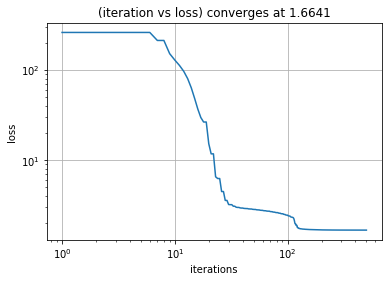

0


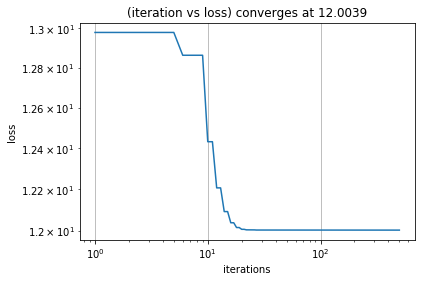

1


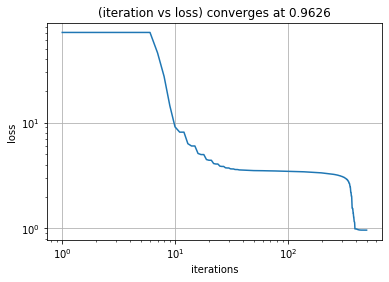

2


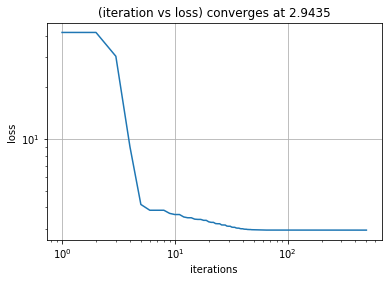

3


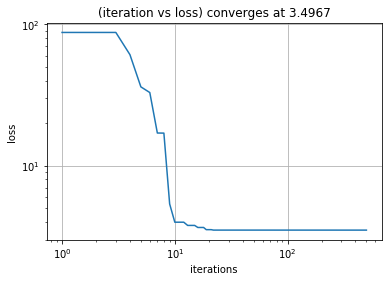

4


In [11]:
lambda_ = 10**-10
lambda_k = 1.5
lowest_loss,best_w,highest_loss,worst_w,X,Y,iter_d,best_run,worst_run=multiple_runs(X,Y,lambda_,lambda_k, 5)

## From the graphs above, we can see which iterations performed the best and worst

### Here are the analytics for the best run:

Lowest Loss: 0.962644663080845
Mean Absolute Error: 0.034105
Mean Absolute Percent Error: 8.080 %


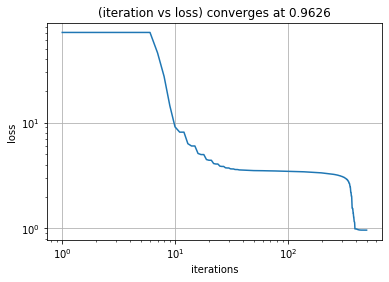


We can see that does not converge to our stopping criterion of 0.1. 
Although that may seem like a significant margin, its important to remember 
that loss (defined earlier) is not the same as error.

When we calculate the mean absolute error, we notice that the average error for this run is: 0.03410

Furthermore, the mean absolute percent error for this run is about 8.080 %.


In [12]:
print('Lowest Loss: {}'.format(lowest_loss))
best_preds = test_NN(X,best_w)
best_ERR = get_ERR(best_preds,Y)

best_avg_err = MAE(best_ERR,Y)
best_avg_percent_err = MAPE(best_ERR,Y)
print('Mean Absolute Error: {:0.6f}\nMean Absolute Percent Error: {:0.3f} %'.format(best_avg_err,best_avg_percent_err))
b_rmse = RMSE(best_ERR,Y)
b_rmspe = RMSPE(best_ERR, Y)

# print('Root Mean Square Error: {:0.6f}\nRoot Mean Square Percent Error: {:0.3f} %'.format(b_rmse,b_rmspe))
plot_loss(iter_d[best_run])


print('\nWe can see that does not converge to our stopping criterion of 0.1. \n\
Although that may seem like a significant margin, its important to remember \n\
that loss (defined earlier) is not the same as error.\n')

print('When we calculate the mean absolute error, we notice that the average error \
for this run is: {:0.5f}\n'.format(best_avg_err))

print('Furthermore, the mean absolute percent error for this run is about {:0.3f} %.'.format(best_avg_percent_err))

#### Here are the analytics for the worst run:

This model performs significantly worse than our best run, which is expected.

Highest Loss: 12.003909373749424
Mean Absolute Error: 0.116241
Mean Absolute Percent Error: 35.614 %


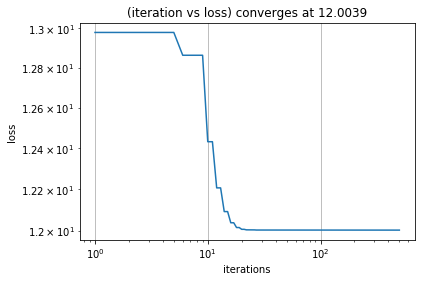

In [13]:
print('Highest Loss: {}'.format(highest_loss))
worst_preds = test_NN(X,worst_w)
worst_ERR = get_ERR(worst_preds,Y)

worst_avg_err = MAE(worst_ERR,Y)
worst_avg_percent_err = MAPE(worst_ERR,Y)
print('Mean Absolute Error: {:0.6f}\nMean Absolute Percent Error: {:0.3f} %'.format(worst_avg_err,worst_avg_percent_err))

w_rmse = RMSE(worst_ERR,Y)
w_rmspe = RMSPE(worst_ERR, Y)

# print('Root Mean Square Error: {:0.6f}\nRoot Mean Square Percent Error: {:0.3f} %'.format(w_rmse,w_rmspe))

plot_loss(iter_d[worst_run])

### The previous results are from the training set. We should also test our best-run model on a completely different random testing set to see how it performs.

We create 3 different testing sets each of a different size. Then we input these sets into our best-run model and calculate the performance.

In [14]:
Xtest1=init_X(50,3)
Ytest1=init_Y(Xtest1)

Xtest2=init_X(150,3)
Ytest2=init_Y(Xtest2)

Xtest3=init_X(300,3)
Ytest3=init_Y(Xtest3)

In [15]:
preds1 = test_NN(Xtest1, best_w)
ERR1 = get_ERR(preds1,Ytest1)

avg_err1 = MAE(ERR1,Ytest1)
avg_percent_err1 = MAPE(ERR1,Ytest1)
err1_rmse = RMSE(ERR1,Ytest1)
err1_rmspe = RMSPE(ERR1,Ytest1)

print('TEST SET 1- 50 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err1,avg_percent_err1))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err1_rmse,err1_rmspe))


preds2 = test_NN(Xtest2, best_w)
ERR2 = get_ERR(preds2,Ytest2)

avg_err2 = MAE(ERR2,Ytest2)
avg_percent_err2 = MAPE(ERR2,Ytest2)
err2_rmse = RMSE(ERR2,Ytest2)
err2_rmspe = RMSPE(ERR2,Ytest2)

print('\nTEST SET 2 - 150 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err2,avg_percent_err2))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err2_rmse,err2_rmspe))


preds3 = test_NN(Xtest3, best_w)
ERR3 = get_ERR(preds3,Ytest3)

avg_err3 = MAE(ERR3,Ytest3)
avg_percent_err3 = MAPE(ERR3,Ytest3)
err3_rmse = RMSE(ERR3,Ytest3)
err3_rmspe = RMSPE(ERR3,Ytest3)

print('\nTEST SET 3 - 300 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err3,avg_percent_err3))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err3_rmse,err3_rmspe))


TEST SET 1- 50 test samples
MAE: 0.036671
MAPE: 7.707 %

TEST SET 2 - 150 test samples
MAE: 0.039760
MAPE: 8.816 %

TEST SET 3 - 300 test samples
MAE: 0.041262
MAPE: 10.584 %


### We can observe that Test set 3, with the most test samples, tends to have the best performance (lowest average error). However, all 3 test sets perform worse than our training set. 

This is expected though. Since we ran multiple iterations on our training set, our model is best fit to the data points from the training set. Both the test and training sets were randomized in the same way, the only thing that differs is the size of each set. Through multiple trials, the size of the test samples did not affect the MAPE that much. 



## Now, we will see how this algorithm performs on a different non-linear function Y

Since our Neural Network model must have X at dimension=3, we will keep the same method of initializing X.

however, Y is now defined as 

$$ Y = G(x) = x_{1}^{x_{2}} + x_{3} $$

We randomly create the training samples again, this time with the new Y.

In [16]:
def init_new_Y(X):
    Y = X[0]**X[1]+X[2]
    Y=Y.reshape(Y.shape[0],1)
    return Y


### Lets also keep our $\lambda$ and $\lambda^{(k)}$ the same

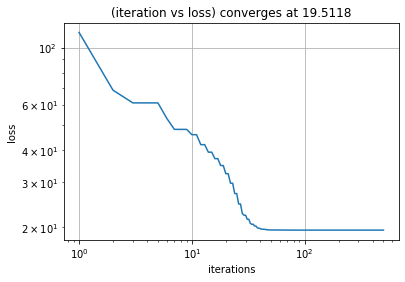

0


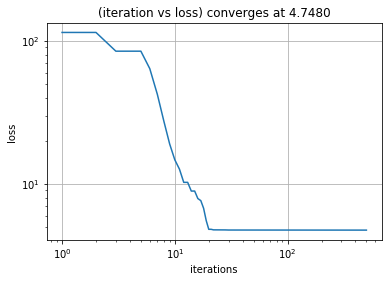

1


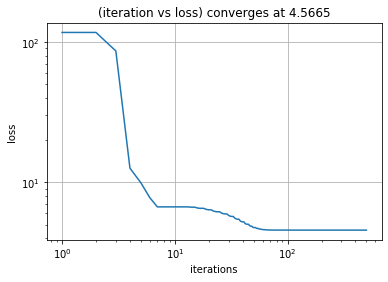

2


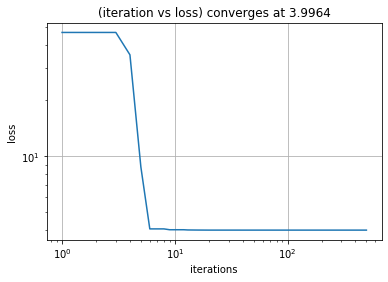

3


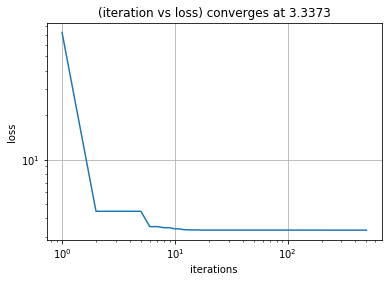

4


In [17]:
X = init_X()
Y = init_new_Y(X)
lambda_ = 10**-10
lambda_k = 1

lowest_loss,best_w,highest_loss,worst_w,X,Y,iter_d,best_run,worst_run=multiple_runs(X,Y,lambda_,lambda_k, 5)

Lowest Loss: 3.3373224198349405
Mean Absolute Error: 0.059868
Mean Absolute Percent Error: 6.005 %


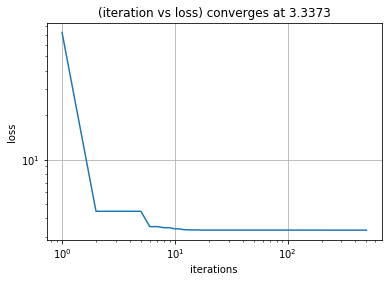

In [18]:
print('Lowest Loss: {}'.format(lowest_loss))
best_preds = test_NN(X,best_w)
best_ERR = get_ERR(best_preds,Y)

best_avg_err = MAE(best_ERR,Y)
best_avg_percent_err = MAPE(best_ERR,Y)
print('Mean Absolute Error: {:0.6f}\nMean Absolute Percent Error: {:0.3f} %'.format(best_avg_err,best_avg_percent_err))
b_rmse = RMSE(best_ERR,Y)
b_rmspe = RMSPE(best_ERR, Y)

# print('Root Mean Square Error: {:0.6f}\nRoot Mean Square Percent Error: {:0.3f} %'.format(b_rmse,b_rmspe))
plot_loss(iter_d[best_run])

Highest Loss: 19.511834536035426
Mean Absolute Error: 0.149818
Mean Absolute Percent Error: 12.521 %


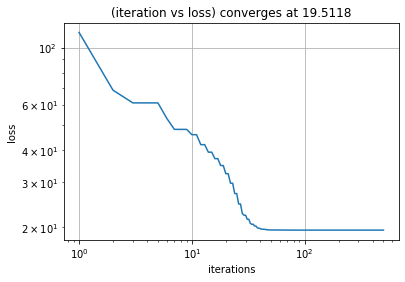

In [19]:
print('Highest Loss: {}'.format(highest_loss))
worst_preds = test_NN(X,worst_w)
worst_ERR = get_ERR(worst_preds,Y)

worst_avg_err = MAE(worst_ERR,Y)
worst_avg_percent_err = MAPE(worst_ERR,Y)
print('Mean Absolute Error: {:0.6f}\nMean Absolute Percent Error: {:0.3f} %'.format(worst_avg_err,worst_avg_percent_err))

w_rmse = RMSE(worst_ERR,Y)
w_rmspe = RMSPE(worst_ERR, Y)

# print('Root Mean Square Error: {:0.6f}\nRoot Mean Square Percent Error: {:0.3f} %'.format(w_rmse,w_rmspe))

plot_loss(iter_d[worst_run])
    

In [20]:
Xtest1=init_X(50,3)
Ytest1=init_new_Y(Xtest1)

Xtest2=init_X(150,3)
Ytest2=init_new_Y(Xtest2)

Xtest3=init_X(300,3)
Ytest3=init_new_Y(Xtest3)

In [21]:
preds1 = test_NN(Xtest1, best_w)
ERR1 = get_ERR(preds1,Ytest1)

avg_err1 = MAE(ERR1,Ytest1)
avg_percent_err1 = MAPE(ERR1,Ytest1)
err1_rmse = RMSE(ERR1,Ytest1)
err1_rmspe = RMSPE(ERR1,Ytest1)

print('TEST SET 1- 50 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err1,avg_percent_err1))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err1_rmse,err1_rmspe))


preds2 = test_NN(Xtest2, best_w)
ERR2 = get_ERR(preds2,Ytest2)

avg_err2 = MAE(ERR2,Ytest2)
avg_percent_err2 = MAPE(ERR2,Ytest2)
err2_rmse = RMSE(ERR2,Ytest2)
err2_rmspe = RMSPE(ERR2,Ytest2)

print('\nTEST SET 2 - 150 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err2,avg_percent_err2))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err2_rmse,err2_rmspe))


preds3 = test_NN(Xtest3, best_w)
ERR3 = get_ERR(preds3,Ytest3)

avg_err3 = MAE(ERR3,Ytest3)
avg_percent_err3 = MAPE(ERR3,Ytest3)
err3_rmse = RMSE(ERR3,Ytest3)
err3_rmspe = RMSPE(ERR3,Ytest3)

print('\nTEST SET 3 - 300 test samples')
print('MAE: {:0.6f}\nMAPE: {:0.3f} %'.format(avg_err3,avg_percent_err3))
# print('RMSE: {:0.6f}\nRMSPE: {:0.3f} %\n'.format(err3_rmse,err3_rmspe))

TEST SET 1- 50 test samples
MAE: 0.057905
MAPE: 5.118 %

TEST SET 2 - 150 test samples
MAE: 0.066899
MAPE: 7.297 %

TEST SET 3 - 300 test samples
MAE: 0.063578
MAPE: 6.345 %


## Summary of Analysis

**In the first part of the project**, we attempted to model the function

$$ Y = G(x) = x_{1} * x_{2} + x_{3} $$

On average, our best runs often converged at a loss value between 0.5-1.5. This often produced an average MAPE of 5-7%. We attempted different lambda_ values and noticed that a smaller lambda_ value often resulted in a lower loss convergence. 

We also tested our model on 3 different test sets. Using our best set of weights, our model predicted the test sets with only a slightly worse MAPE. This means that our model is generally consistent on multiple data sets. 


**The second part of the project**, we modeled the non-linear function

$$ Y = G(x) = x_{1}^{x_{2}} + x_{3} $$

We did not need to modify our code from the first part except for updating the Y=G(X) function. Through our 5 iterations of the LM-alg, our best runs converged at a loss around 1-2 and had and average MAPE of around 6-7%. The loss vs iterations graphs look quite similar to the first part of the experiment. We also had similar results when testing the model on 3 different test sets of different sizes. Adjusting the lambda_ values for this part also yielded the same trends as the first part. 
